## Reading the .csv containing the file names and the steering angles

### Loading the file names  and steering angles into samples
### Splitting samples into train and validation samples

In [1]:
import os
def  extractFileName ( ssd_folder, abs_path):
#     print (abs_path)

    if os.name == "nt":
        split_char = '\\' 
    else:
        split_char = '/' 
        
    if '\\' in abs_path:
        # "  Windows Path " 
#         print ("windows path ")
        image_name = ssd_folder\
                    +split_char + abs_path.split ('\\')[-2] \
                    + split_char +abs_path.split ('\\')[-1]
#         print (image_name)

    else:
        # "  Unix Path " 
        image_name = ssd_folder \
                     + split_char + abs_path.split ('/')[-2] \
                     + split_char + abs_path.split ('/')[-1]
#         print ( "image_name = " + image_name)
    
    return image_name

#### Defining the resize shape of the images ( this parameter will be used also in the Generator and in the Model definition)

In [2]:
resized_shape = 128

In [3]:
## Defining the batch size:
batch_size = 128

### Defining the Queue loader chunk size  
queue_loader_chunk = 100 # batch_size(32) * 1000 samples, = 32000 images


### Defining the PyTable

In [11]:
ssd_folder = "/ssd_data/project3"

In [4]:
from  tables import *
import tables


In [5]:
# hdf5_file.close()

In [12]:
hdf5_file = open_file(ssd_folder + "/samples.hdf5", mode = "w", title = "Samples")


### Defining the two objects as images container:


In [13]:
py_training_samples = hdf5_file.create_earray(hdf5_file.root, \
                    'train_img', \
                    tables.UInt8Atom(), \
                    shape=( 0,resized_shape, resized_shape, 3),chunkshape=(batch_size*queue_loader_chunk ,32,32,3))

py_validation_samples      = hdf5_file.create_earray(hdf5_file.root, \
                     'val_img', tables.UInt8Atom(), \
                     shape=( 0,resized_shape, resized_shape, 3),chunkshape=(batch_size*queue_loader_chunk,32,32,3))



### Copy data folder to ssd

In [14]:
import shutil 

shutil.rmtree(ssd_folder)

In [15]:
import shutil 
print ( "Copying files to ssd ....")
shutil.copytree ("data",ssd_folder)
print ( "... completed")


Copying files to ssd ....
... completed


In [16]:
ssd_folder

'/ssd_data/project3'

In [17]:
import os
import csv
import cv2
import numpy as np
import glob

print ( "Starting .... ")
samples_list = []
center_image_before = None
for name in glob.glob(ssd_folder + "/*.csv"):
    print ( "Reading from logfile = " + name)
    with open(name)  as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                # STEERING ANGLE CALCULATION
                samples_list.append([extractFileName(ssd_folder, line[0]),\
                                     extractFileName(ssd_folder, line[1]),\
                                     extractFileName(ssd_folder, line[2]),\
                                     float(line[3])])
                
samples_list = np.array(samples_list)

from random import shuffle
shuffle(samples_list)

train_list = samples_list[0:int(0.8*len(samples_list))]

val_list = samples_list[int(0.8*len(samples_list)):int(1.0*len(samples_list))]


print ("\n\nThere are {} images in total ".format(len(samples_list)))
print ("....splitted into training images = {}  ".format(len(train_list)))
print ("                  val images      = {}  ".format(len(val_list)))


Starting .... 
Reading from logfile = /ssd_data/project3/run3.csv
Reading from logfile = /ssd_data/project3/run4.csv
Reading from logfile = /ssd_data/project3/run2.csv
Reading from logfile = /ssd_data/project3/run1.csv


There are 10241 images in total 
....splitted into training images = 8192  
                  val images      = 2049  


In [18]:
# train_list = train_list[0:100 ]
# train_list.shape

In [19]:
def data_preprocess(line):
        preprocessed_samples=[]
        # STEERING ANGLE CALCULATION
        correction = 0.03 # this is a parameter to tune
        center_steering = float(line[3])
        left_steering   = center_steering + correction
        right_steering  = center_steering - correction

        # CENTER IMAGE
        center_image = cv2.imread(extractFileName( ssd_folder, line[0]))
#         print (extractFileName(ssd_folder,  line[0]))
        center_image = cv2.cvtColor (center_image, cv2.COLOR_BGR2RGB)
        center_image = cv2.resize(center_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([center_image, center_steering ])

        #   LEFT IMAGE
        left_image = cv2.imread(extractFileName(ssd_folder,  line[1]))
        left_image = cv2.cvtColor (left_image, cv2.COLOR_BGR2RGB)
        left_image = cv2.resize(left_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([left_image, left_steering ])

        #   RIGHT IMAGE
        right_image = cv2.imread(extractFileName(ssd_folder,  line[2]))
        right_image = cv2.cvtColor (right_image, cv2.COLOR_BGR2RGB)
        right_image = cv2.resize(right_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([right_image, right_steering ])


        ###
        ### IMAGE AUGMENTATION
        ###
        # augmented center image
        preprocessed_samples.append([cv2.flip(center_image,1), center_steering*-1.0 ])

        # augmented left image
        preprocessed_samples.append([cv2.flip(left_image  ,1), left_steering  *-1.0] )

        # augmented right image
        preprocessed_samples.append([cv2.flip(right_image,1),  right_steering *-1.0] )
        
#         print ( "here 1 {}".format( np.array(preprocessed_samples).shape))
        return np.array(preprocessed_samples)

### Image preprocessing using the function defined before

In [21]:
    
import os
import csv
import cv2
import numpy as np
import glob

print ( "Starting Preprocessing the images  .... ")
train_samples      =  np.array([]).reshape(0,2)
validation_samples =  np.array([]).reshape(0,2)
training_steering = []
val_steering = []

for i,sample_line in enumerate(train_list):
   for output in data_preprocess(sample_line):
#         print (output[0].shape)
        try:
            py_training_samples.append(output[0][None])
            training_steering.append(output[1])
        except ValueError:
            print (" Image not found " +sample_line[0] )
            
   if i% 1000 == 0 and i> 0 : print(".. training samples processed {}".format(i))     
   
for i,sample_line in enumerate(val_list):
   for output in data_preprocess(sample_line):
#         print ( "output[0].shape" + str(output[0].shape))
        py_validation_samples.append(output[0][None])
        val_steering.append(output[1])
#         print (output[0][None].shape)

   if i% 1000 == 0 and i> 0 : print(".. validation samples processed {}".format(i))     


print ("\nTotal training samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(py_training_samples)) ))
print ("\nTotal validation samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(py_validation_samples)) ))
print ( "... completed")


Starting Preprocessing the images  .... 
.. training samples processed 1000
.. training samples processed 2000
.. training samples processed 3000
.. training samples processed 4000
.. training samples processed 5000
.. training samples processed 6000
.. training samples processed 7000
.. training samples processed 8000
.. validation samples processed 1000
.. validation samples processed 2000

Total training samples 128x128 after augmentation and preprocessing : 98304 

Total validation samples 128x128 after augmentation and preprocessing : 24588 
... completed


### Trying to simulate a "Recurrent neural network"
#### inserting previous 3  images with current steering wheel angle

In [22]:
print ( "Starting Preprocessing the images  .... ")

for i,sample_line in enumerate(train_list):
   if i > 10: 
       current_steering_angle = sample_line[3]
       for ix in range ( i-1 , i-4 , -1):
           sample_line_prev  = [train_list[ix][0],train_list[ix][1],train_list[ix][2],current_steering_angle]
           for output in data_preprocess(sample_line_prev):
                py_training_samples.append(output[0][None])
                training_steering.append(output[1])
          
   if i% 1000 == 0 and i> 0 : print(".. training samples processed {}".format(i))     
    

print ("\nTotal training samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(py_training_samples)) ))

Starting Preprocessing the images  .... 
.. training samples processed 1000
.. training samples processed 2000
.. training samples processed 3000
.. training samples processed 4000
.. training samples processed 5000
.. training samples processed 6000
.. training samples processed 7000
.. training samples processed 8000

Total training samples 128x128 after augmentation and preprocessing : 245562 


In [23]:
len(py_training_samples)

245562

In [24]:
len(training_steering)

196410

### Defining the table arrays and copying the labels data inside


In [25]:
py_training_steerings = hdf5_file.create_array(hdf5_file.root, 'py_training_steering',training_steering )
py_validation_steerings = hdf5_file.create_array(hdf5_file.root, 'py_val_steering', val_steering)

## EXPLORING THE DATA


Exploring the dataset ...


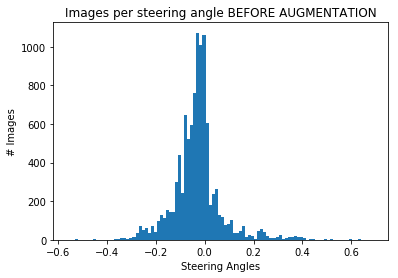

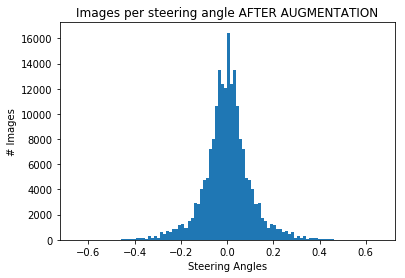

Exploring the dataset complete.


In [26]:
import matplotlib.pyplot as plt
 
print("\nExploring the dataset ...")
 
# It plots the histogram of an arrray of angles: [0.0,0.1, ..., -0.1]
def plot_steering_histogram(steerings, title, num_bins=100):
    plt.hist(steerings, num_bins)
    plt.title(title)
    plt.xlabel('Steering Angles')
    plt.ylabel('# Images')
    plt.show()
 
# # It plots the histogram of an arrray of associative arrays of angles: [{'steering':0.1}, {'steering':0.2}, ..., {'steering':-0.1}]
def plot_dataset_histogram(samples, title, num_bins=100):
    steerings = []
    for item in samples:
#         print (item)
        steerings.append( float(item) )
    plot_steering_histogram(steerings, title, num_bins)

samples_before = samples_list[:,3]
# Plot the histogram of steering angles before the image augmentation
plot_dataset_histogram(samples_before, 'Images per steering angle BEFORE AUGMENTATION', num_bins=100)
samples_before = []

# Plot the histogram of steering angles after the image augmentation
plot_dataset_histogram(training_steering, 'Images per steering angle AFTER AUGMENTATION', num_bins=100)
print("Exploring the dataset complete.")
samples=[]




## Model definition using Keras

#### NVIDIA model used
#### Image normalization to avoid saturation and make gradients work better.
####     Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
####     Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
####     Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
####     Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
####     Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
####     Drop out (0.5)
####     Fully connected: neurons: 100, activation: ELU
####     Fully connected: neurons: 50, activation: ELU
####     Fully connected: neurons: 10, activation: ELU
####     Fully connected: neurons: 1 (output)

In [27]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Activation, Dropout, Reshape, LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
top_crop = int(resized_shape*10/100)
bottom_crop = int(resized_shape*34/100)

# Data Preprocessing ( Normalization and mean centering)
model.add(Cropping2D(cropping =((bottom_crop,top_crop),(0,0)), input_shape = (resized_shape,resized_shape,3), name ="cropping") )
model.add(Lambda(lambda x: x/127.5 - 1. , input_shape = (resized_shape,resized_shape,3)))
model.add(Dropout(0.5))

model.add(Conv2D(24, (5, 5), activation='linear', padding='valid',strides=(2, 2), name = "Conv1"))
model.add(LeakyReLU(alpha=.001))   # add an advanced activation
model.add(Dropout(0.5))

model.add(Conv2D(36, (5, 5), activation='linear', padding='valid',strides=(2, 2), name = "Conv2"))
model.add(LeakyReLU(alpha=.001))   # add an advanced activation
model.add(Dropout(0.5))

model.add(Conv2D(48, (5, 5), activation='linear', padding='valid',strides=(2, 2), name = "Conv3"))
model.add(LeakyReLU(alpha=.001))   # add an advanced activation
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='linear', padding='valid',strides=(1, 1), name = "Conv4"))
model.add(LeakyReLU(alpha=.001))   # add an advanced activation
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='linear', padding='valid',strides=(1, 1), name = "Conv5"))
model.add(LeakyReLU(alpha=.001))   # add an advanced activation

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(100))
model.add(LeakyReLU(alpha=.001))   # add an advanced activation
model.add(Dropout(0.5))

model.add(Dense(50))
model.add(LeakyReLU(alpha=.001))   # add an advanced activation

model.add(Dense(10))
model.add(LeakyReLU(alpha=.001))   # add an advanced activation

model.add(Dense(1,kernel_initializer='random_uniform',bias_initializer='zeros'))

model.compile(loss='mse', optimizer='adam')

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping (Cropping2D)        (None, 73, 128, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 73, 128, 3)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 73, 128, 3)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 35, 62, 24)        1824      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 35, 62, 24)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 35, 62, 24)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 29, 36)        21636     
__________

## Defining the generators .
### This flushes the files content from disk and return it to Tensorflow for the training fit
### The generator is repeated many times ( as many Epochs of training )



### Defining the Queue Thread process
#### Here I am creating a function that will be called in a separate thread . This simply read big Chunks from Disk ( also the Pytable ) , shuffle them, and make them at disposition of a further processer in a Python Queue.
#### The size of this two Queue , samples_q and labels_q is defined as batch_size * 100, so for example 3200 samples
#### The great thing about Python Queue is that , if we define the maxsize, the put instruction in case the Queue is full, will wait until will be some space free. 
#### **** This is useful to AVOID TO LOAD THE ENTIRE PYTABLE IN MEMORY ****

#### Splitting the  Pytable into two different table with 50/50% number of records

In [28]:
# hdf5_file_part1.close()
# hdf5_file_part2.close()
# hdf5_file.close()

In [29]:
from  tables import *
import tables

hdf5_file_part1 = open_file(ssd_folder + "/samples_part1.hdf5", mode = "w", title = "Samples_part1")
py_training_samples_part1       = hdf5_file_part1.create_earray(hdf5_file_part1.root, \
                                'train_img', \
                                tables.UInt8Atom(), \
                                shape=( 0,resized_shape, resized_shape, 3))

py_validation_samples_part1      = hdf5_file_part1.create_earray(hdf5_file_part1.root, \
                                 'val_img', tables.UInt8Atom(), \
                                 shape=( 0,resized_shape, resized_shape, 3))


#### Second file ( if you have a second SSD this can be put on a different Disk)

In [30]:
hdf5_file_part2 = open_file(ssd_folder + "/samples_part2.hdf5", mode = "w", title = "Samples_part1")
py_training_samples_part2       = hdf5_file_part1.create_earray(hdf5_file_part2.root, \
                                'train_img', \
                                tables.UInt8Atom(), \
                                shape=( 0,resized_shape, resized_shape, 3))

py_validation_samples_part2      = hdf5_file_part1.create_earray(hdf5_file_part2.root, \
                                 'val_img', tables.UInt8Atom(), \
                                 shape=( 0,resized_shape, resized_shape, 3))

#### Splitting the py_training_samples

In [31]:
print ( " Start splitting Training Samples......")
n_rec = len(py_training_samples)
n_rec_tr_1 =  int(n_rec * 0.5)
n_rec_tr_2 = n_rec - n_rec_tr_1

for i, training_sample in enumerate(py_training_samples):
    if i < n_rec_tr_1:
        py_training_samples_part1.append(training_sample[None])
    else:
        py_training_samples_part2.append(training_sample[None])
print ( "... completed")

print ( "\nTraining Sample table before splitting . Nrecords = {}".format(n_rec))
print ( "               py_training_samples_part1 Nrecords = {}".format(len(py_training_samples_part1)))
print ( "               py_training_samples_part1 Nrecords = {}".format(len(py_training_samples_part2)))


 Start splitting Training Samples......
... completed

Training Sample table before splitting . Nrecords = 245562
               py_training_samples_part1 Nrecords = 122781
               py_training_samples_part1 Nrecords = 122781


In [32]:
# py_training_samples

In [33]:
#### Splitting the py_validation_samples

In [34]:
print ( " Start splitting Validation Samples......")
n_rec = len(py_validation_samples)

n_rec_val_1 =  int(n_rec * 0.5)
n_rec_val_2 = n_rec - n_rec_val_1

for i, validation_sample in enumerate(py_validation_samples):
    if i < n_rec * 0.5:
        py_validation_samples_part1.append(validation_sample[None])
    else:
        py_validation_samples_part2.append(validation_sample[None])
print ( "... completed")

print ( "\nValidation Sample table before splitting . Nrecords = {}".format(n_rec))
print ( "               py_validation_samples_part1   Nrecords = {}".format(len(py_validation_samples_part1)))
print ( "               py_validation_samples_part2   Nrecords = {}".format(len(py_validation_samples_part2)))


 Start splitting Validation Samples......
... completed

Validation Sample table before splitting . Nrecords = 24588
               py_validation_samples_part1   Nrecords = 12294
               py_validation_samples_part2   Nrecords = 12294


#### Splitting the steerings angle... the training labels and validation labels

In [23]:
n_rec = len(py_training_samples)
n_rec_tr_1 =  int(n_rec * 0.5)
n_rec_tr_2 = n_rec - n_rec_tr_1
n_rec_tr_2

98205

In [24]:
py_training_steerings_part1 = hdf5_file_part1.create_array(
                               hdf5_file_part1.root, 
                              'py_training_steering',
                               training_steering[0:n_rec_tr_1]) 


In [25]:
py_training_steerings_part2 = hdf5_file_part2.create_array(
                               hdf5_file_part2.root, 
                              'py_training_steering',
                               training_steering[n_rec_tr_1:]) 


In [26]:
print ( "Training Labels table before splitting . Nrecords = {}".format(len(training_steering)))
print ( "               py_training_steerings_part1   Nrecords = {}".format(len(py_training_steerings_part1)))
print ( "               py_training_steerings_part2   Nrecords = {}".format(len(py_training_steerings_part2)))

Training Labels table before splitting . Nrecords = 196410
               py_training_steerings_part1   Nrecords = 98205
               py_training_steerings_part2   Nrecords = 98205


##### validation labels

In [27]:
py_validation_steerings_part1 = hdf5_file_part1.create_array(
                               hdf5_file_part1.root, 
                              'py_validation_steering',
                               val_steering[0:n_rec_val_1]) 

In [28]:
py_validation_steerings_part2 = hdf5_file_part2.create_array(
                               hdf5_file_part2.root, 
                              'py_validation_steering',
                               val_steering[n_rec_val_1:]) 

In [29]:
print ( "Validation Labels table before splitting . Nrecords = {}".format(len(val_steering)))
print ( "               py_validation_steerings_part1   Nrecords = {}".format(len(py_validation_steerings_part1)))
print ( "               py_validation_steerings_part2   Nrecords = {}".format(len(py_validation_steerings_part2)))

Validation Labels table before splitting . Nrecords = 12294
               py_validation_steerings_part1   Nrecords = 6147
               py_validation_steerings_part2   Nrecords = 6147


In [30]:
import sklearn
from time import sleep 

def read_images_into_queue(samples_q, labels_q , samples, labels):
#     print ( " reading images into Queue")
    # Define the Queue max size , the Queue.put() automatically do wait until records will be get from 
    # an other process and will free some space in the queue.
#     From docs.python.org:
#     The Queue module implements multi-producer, multi-consumer queues. 
#     It is especially useful in threaded programming when information must be exchanged safely between multiple threads. 
#     The Queue class in this module implements all the required locking semantics. 
#     It depends on the availability of thread support in Python; see the threading module.
    
    numsamples = len(samples)
    while 1:  ### remember you need to stop the process !!
#         print ("numsamples = " + str(numsamples))
        for offset in range(0, numsamples, batch_size*queue_loader_chunk):
#              print ( "offset = " + str(offset))
             # loading into memory a BIG chunk of data ( 32* queue_loader_chunk  )
             chunk_batch_samples = samples[offset:offset+batch_size*queue_loader_chunk]
             chunk_batch_labels  = labels[offset:offset+batch_size*queue_loader_chunk]
#              print ("chunk_batch_samples size {}".format(chunk_batch_samples.shape) )
             # shuffle the chunk
#              print ("len chunk_batch_samples " + str(len(chunk_batch_samples)))
#              print ("len chunk_batch_labels " + str(len(chunk_batch_labels)))
#              print ("len chunk_batch_samples " + str(len(chunk_batch_samples)))
#              print ("len chunk_batch_labels " + str(len(chunk_batch_labels)))
             chunk_batch_samples,chunk_batch_labels = sklearn.utils.shuffle(chunk_batch_samples,chunk_batch_labels)  
#              sleep (0.1)
             for sample, steering in zip ( chunk_batch_samples,chunk_batch_labels):
                samples_q.put(sample)
                labels_q.put(steering)
    

#### Starting the reading processes -- from Disk to Memory Queue
#### Remember to TERMINATE them !!

In [31]:
training_producer1.terminate()
training_producer2.terminate()

validation_producer1.terminate()
validation_producer2.terminate()


NameError: name 'training_producer1' is not defined

In [52]:
from multiprocessing import Process, Queue

training_samples_q = Queue(maxsize = batch_size * queue_loader_chunk)
training_labels_q = Queue(maxsize = batch_size * queue_loader_chunk)

validation_samples_q = Queue(maxsize = batch_size * queue_loader_chunk)
validation_labels_q = Queue(maxsize = batch_size * queue_loader_chunk)

###############################################################
# Training Producers . They load training data into Queues
###############################################################
training_producer1 = Process(target=read_images_into_queue, 
                            args=(training_samples_q,            # <-- Training images queue
                                  training_labels_q,             # <-- Training labels queue
                                  py_training_samples_part1,           # <-- Training samples Pytable
                                  py_training_steerings_part1))        # <-- Training labels  Pytable
training_producer1.start()

training_producer2 = Process(target=read_images_into_queue, 
                            args=(training_samples_q,            # <-- Training images queue
                                  training_labels_q,             # <-- Training labels queue
                                  py_training_samples_part2,           # <-- Training samples Pytable
                                  py_training_steerings_part2))        # <-- Training labels  Pytable
training_producer2.start()


###############################################################
# Validation Producers. They load validation data into Queues
###############################################################
validation_producer1 = Process(target=read_images_into_queue, 
                            args=(validation_samples_q,              # <-- Training images queue
                                  validation_labels_q,               # <-- Training labels queue
                                  py_validation_samples_part1,           # <-- Training samples Pytable
                                  py_validation_steerings_part1))        # <-- Training labels  Pytable
validation_producer1.start()

validation_producer2 = Process(target=read_images_into_queue, 
                            args=(validation_samples_q,              # <-- Training images queue
                                  validation_labels_q,               # <-- Training labels queue
                                  py_validation_samples_part2,           # <-- Training samples Pytable
                                  py_validation_steerings_part2))        # <-- Training labels  Pytable
validation_producer2.start()


## training_producer1.terminate()
## training_producer2.terminate()

## validation_producer1.terminate()
## validation_producer2.terminate()



Process Process-5:
Traceback (most recent call last):
  File "/home/cristianku/anaconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/cristianku/anaconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-30-ea33af74b398>", line 31, in read_images_into_queue
    samples_q.put(sample)
  File "/home/cristianku/anaconda3/envs/carnd-term1/lib/python3.5/multiprocessing/queues.py", line 82, in put
    if not self._sem.acquire(block, timeout):
KeyboardInterrupt


In [33]:
len(py_training_samples_part1)

98205

In [34]:
training_samples_q.qsize()

12800

In [35]:
queue_loader_chunk

100

#### Defining the epochs

In [ ]:
epochs = 1

In [53]:
#### Defining thread safe generator
import cv2
import numpy as np
import sklearn
import threading

class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def generator(samples_q, labels_q, batch_size ):
    read_nb = 0
    while 1: # Loop forever so the generator never terminates
        
        images = []
        angles=[]
        for i in range(0, batch_size):
            images.append(samples_q.get())
            angles.append(labels_q.get())

        yield np.array(images) , np.array(angles)


#### Creating the Train and Validation generators:

In [54]:
## Note that the traing_generator uses Queue and async thread !
train_generator      = generator(training_samples_q, 
                                 training_labels_q, 
                                 batch_size)

validation_generator = generator(validation_samples_q, 
                                 validation_labels_q, 
                                 batch_size)

#### Training the model using traing_generator and validating with validation_generator

In [39]:
epochs = 20

from datetime import datetime
start_time = datetime.now()

model.compile(loss='mse', optimizer='adam')

numper_of_train_samples      = len(py_training_samples)
number_of_validation_samples = len(py_validation_samples) 

history_object = model.fit_generator(train_generator, steps_per_epoch= \
                                     numper_of_train_samples/batch_size, 
                                     validation_data=validation_generator, \
                                     validation_steps=number_of_validation_samples/batch_size, 
                                     epochs=epochs, verbose = 1,\
                                     workers=2)

end_time = datetime.now()
print('\nTotal number of train samples: {} ( shape {}x{})'.format(numper_of_train_samples,resized_shape,resized_shape))
print('\nBatch Size                   : {}'.format(batch_size))
print('\nDuration                     : {}'.format(end_time - start_time))

from keras.models import save_model

save_model(model, "selfdrive_model.h5")
print ( "  ")
print ( " .. model saved to selfdrive_model.h5 ")
print ( "  ")


### print the keys contained in the history object
# print(history_object.history.keys())

import matplotlib.pyplot as plt
# # # Visualizations will be shown in the notebook.
%matplotlib inline

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

training_producer1.terminate()
training_producer2.terminate()

validation_producer1.terminate()
validation_producer2.terminate()


Epoch 1/20
1535/1534 [==============================] - 67s - loss: 0.0107 - val_loss: 0.0129
Epoch 2/20
1535/1534 [==============================] - 62s - loss: 0.0107 - val_loss: 0.0131
Epoch 3/20
1535/1534 [==============================] - 62s - loss: 0.0106 - val_loss: 0.0133
Epoch 4/20
1535/1534 [==============================] - 62s - loss: 0.0107 - val_loss: 0.0127
Epoch 5/20
1535/1534 [==============================] - 62s - loss: 0.0106 - val_loss: 0.0133
Epoch 6/20
1535/1534 [==============================] - 62s - loss: 0.0107 - val_loss: 0.0129
Epoch 7/20
1535/1534 [==============================] - 62s - loss: 0.0107 - val_loss: 0.0130
Epoch 8/20
1535/1534 [==============================] - 62s - loss: 0.0107 - val_loss: 0.0128
Epoch 9/20
1535/1534 [==============================] - 61s - loss: 0.0107 - val_loss: 0.0132
Epoch 10/20
1535/1534 [==============================] - 61s - loss: 0.0108 - val_loss: 0.0130
Epoch 11/20
1341/1534 [=========================>....] - ET

KeyboardInterrupt: 

In [40]:
training_producer1.terminate()
training_producer2.terminate()

validation_producer1.terminate()
validation_producer2.terminate()

#### Image Convolution broken down in small pieces 

### Here I am trying to visualize the Convolution Layers to understand visually how many filters I should use

In [ ]:
# print (" Loading drive.h5 .......")

# from keras.models import load_model
# from keras.models import Model

# modelobj = load_model('drive.h5')
# print (" ..... model drive.h5 successfully loaded")


#### For this purpose I am loading a Test image from disk

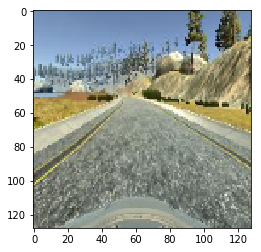

In [51]:
plt.imshow(py_training_samples_part1[3000], cmap='gray')

plt.show()

In [ ]:
# # Load test images
# import cv2
# import numpy as np
# test_images = []

# image = cv2.imread('./test_images/center1.jpg')
# image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image,(resized_shape,resized_shape ))     
# test_images.append(image)


# test_images = np.array(test_images)


#### First of all I am looking at the Image Crop if is well done in the right position:

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'cropping'
# intermediate_layer_model = Model(inputs=modelobj.input,
#                                  outputs=modelobj.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# intermediate_output.shape


In [ ]:
# # Show the cropped images
# def show_intermediate_output(image_ori, intermediate_output):
#     print (intermediate_output.shape)
#     depth = 0 
#     %matplotlib inline
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(20, 100))
#     new_image = []
#     plt.subplot(40, 5, 1 )
#     plt.axis('off')
#     plt.imshow(image_ori)
#     for i in range(0,intermediate_output[0,0].shape[0]):
#            single_output = intermediate_output[:,:,i]
# #            print ( "single_output.shape {}".format(single_output.shape ))
# #            print ( single_output)
#            plt.subplot(40, 5, i+2 )
#            plt.axis('off')
#            single_output = single_output.astype(np.uint8)
#            plt.imshow(single_output, cmap='gray')
#     plt.show()    

    
# show_intermediate_output(test_images[0], intermediate_output[0])

#### Now the FIRST convolutional layer:

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv1'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

#### Now the SECOND convolutional layer:

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv2'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 3

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv3'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 4

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv4'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Model Visualization

In [ ]:
# import cv2
# from keras.utils.visualize_util import plot
# from keras.models import load_model
# %matplotlib inline

# #visualize the model
# modelobj = load_model('model.h5')
# plot (modelobj, to_file='model.png')
# import matplotlib.pyplot as plt

# plt.figure(figsize=(100, 100))
# image = cv2.imread('model.png')
# image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
# plt.subplot(5, 5, 1)
# plt.axis('off')

# plt.imshow(image)
# plt.show()
